# Network per channel

As we dive more precisely into the topic, we now create a more robust dataset:

* each input is an image of size `(C, W, H)`. On each channel, there is a grayscale sliced image. So, 
  * the first `C/3` channels are sliced images along x axis
  * the following `C/3` channels are sliced images along x axis
  * the last `C/3` channels are sliced images along x axis
* each output is list of fabric descriptors

If we take `C=3`, we can use a pretrained VGG model. Indeed, this model is trained on RGB images, which have 3 channels.

# Importing the dataframe

Firstly, we initialize wandb. It is a tool that allows to store the losses and retrieve the deframe. Otherwise, you can directly access locally the dataframe on your computer.

In [ ]:
!pip install wandb --upgrade

We import all the useful packages.

In [1]:
import sys
from pathlib import Path

IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules
if IS_KAGGLE:
    repo_path = Path("../input/microstructure-reconstruction")
elif IS_COLAB:
    from google.colab import drive

    drive.mount("/content/gdrive")
    repo_path = Path("/content/gdrive/MyDrive/microstructure-reconstruction")
else:
    repo_path = Path("/home/matias/microstructure-reconstruction")
sys.path.append(str(repo_path))

from copy import deepcopy
from importlib import reload

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.optim as optim
import torchmetrics
import wandb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader
from torchvision import models as pretrained_models
from torchvision import transforms, utils
from tqdm import tqdm

from custom_datasets import dataset
from custom_models import models
from tools import dataframe_reformat, inspect_code, plotting, training, wandb_api

log_wandb = False

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {"num_workers": 2, "pin_memory": True} if use_cuda else {"num_workers": 4}
print(f"[INFO]: Computation device: {device}")


[INFO]: Computation device: cpu


We initialize a wandb run, that will save our metrics

In [6]:
fabrics_df = pd.read_csv(repo_path / "REV1_600/fabrics.txt")
path_to_slices = repo_path / "REV1_600/REV1_600Slices"
fabrics_df["photos"] = fabrics_df["id"].apply(
    func=dataframe_reformat.associate_rev_id_to_its_images,
    args=(path_to_slices, 3, repo_path),
)
fabrics_df["photos"] = fabrics_df["photos"].apply(
    func=lambda photo_paths: [str(repo_path / Path(x)) for x in photo_paths]
)
fabrics_df = fabrics_df[fabrics_df.photos.str.len().gt(0)]
fabrics_df = fabrics_df.sample(frac=config["frac_sample"], random_state=config["seed"])
fabrics_df


,id,orientation-0_mean,orientation-1_mean,orientation-2_mean,orientation-3_mean,orientation-4_mean,orientation-5_mean,orientation-0_std,orientation-1_std,orientation-2_std,...,aspectratio-0_std,aspectratio-1_std,size_mean,size_std,solidity_mean,solidity_std,roundness_mean,roundness_std,volume_fraction,photos
111,Spec-199,0.340500,0.321285,0.338215,-0.008812,-0.000788,0.003326,0.304648,0.302155,0.310230,...,0.137878,0.101578,12.758537,3.920147,0.855135,0.093256,0.206649,0.081536,0.347122,[/home/matias/microstructure-reconstruction/RE...
420,Spec-477,0.140781,0.131637,0.727582,0.242003,0.006315,-0.001847,0.154697,0.135059,0.169285,...,0.137516,0.108505,11.281476,2.126035,0.925336,0.074298,0.275651,0.119497,0.091461,[/home/matias/microstructure-reconstruction/RE...
566,Spec-68,0.350577,0.323444,0.325980,0.004078,0.007206,-0.012600,0.308358,0.302684,0.304662,...,0.140101,0.104154,12.878511,3.812330,0.851472,0.098154,0.205729,0.086907,0.407607,[/home/matias/microstructure-reconstruction/RE...
78,Spec-169,0.353518,0.323367,0.323115,-0.002773,0.005499,0.008358,0.314684,0.298870,0.302726,...,0.137758,0.107203,12.924555,4.120053,0.846134,0.105053,0.212573,0.092038,0.415207,[/home/matias/microstructure-reconstruction/RE...
182,Spec-262,0.328198,0.328981,0.342821,-0.007508,-0.024902,0.014861,0.305752,0.303890,0.309204,...,0.140087,0.116953,12.246303,2.920092,0.908055,0.101011,0.277904,0.126039,0.406908,[/home/matias/microstructure-reconstruction/RE...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,Spec-163,0.310736,0.349786,0.339478,-0.005327,-0.000082,0.003391,0.297220,0.305787,0.309034,...,0.138733,0.105004,10.398206,2.797734,0.877064,0.054819,0.217739,0.089788,0.216830,[/home/matias/microstructure-reconstruction/RE...
107,Spec-195,0.335551,0.339138,0.325312,-0.001358,0.011718,-0.014050,0.309818,0.312565,0.307158,...,0.143635,0.102686,13.459184,4.464352,0.847222,0.103073,0.206318,0.086632,0.385221,[/home/matias/microstructure-reconstruction/RE...
271,Spec-342,0.334104,0.331458,0.334438,0.000891,0.002602,0.011794,0.313064,0.313294,0.313087,...,0.141975,0.124556,10.969777,2.483673,0.956011,0.078309,0.353728,0.148757,0.308272,[/home/matias/microstructure-reconstruction/RE...
436,Spec-491,0.144886,0.140017,0.715096,0.251179,-0.011591,-0.003892,0.153152,0.142701,0.171072,...,0.138290,0.117119,11.570258,2.803110,0.920576,0.084933,0.278994,0.129881,0.174805,[/home/matias/microstructure-reconstruction/RE...


In [84]:
from PIL import Image


class NChannelPhotosDataset(dataset.SinglePhotoDataset):
    """Dataset whose inputs are images of size `(C, W, H)`. On each channel, there is a white and black image corresponding to a sliced image.

    Attributes:
        nb_input_photos_per_plane (int): number of sliced images per plane in the input. For instance,
            if we chose `nb_input_photos_per_plane=2`, the input will have a size `(nb_input_photos_per_plane*3, W, H)`:
                * the first 2 images are sliced images from x plane
                * the 2 next images are sliced images from y plane
                * the 2 final images are sliced images from z plane
    """
    def compute_photos_along_axis(self, df, axis):
        nb_photos_per_plane = df["photos"].apply(len).unique().min() // 3
        photos = np.hsplit(
            df["photos"]
            .apply(func=dataframe_reformat.get_path_image_along_axis, args=(axis))
            .explode()
            .to_numpy()
            .reshape(-1, nb_photos_per_plane),
            list(range(0, nb_photos_per_plane, self.nb_input_photos_per_plane)),
        )[1:]
        return np.concatenate([x for x in photos if x.shape[1] == photos[0].shape[1]], axis=0)

    def __init__(
        self,
        df: pd.DataFrame,
        nb_input_photos_per_plane: int = 1,
        transform: transforms.Compose = transforms.Compose([transforms.ToTensor()]),
    ):
        """Constructor

        Args:
            df (pd.DataFrame): original dataframe to be used
            nb_input_photos_per_plane (int): Number of sliced images to use. Defaults to 1.
            normalization (Union[bool, List[float]], optional): normalization parameters
                If a list is provided, the first item is the min and the second item is the max value to use to normalize the data.
                If a bool is provided, it precises whether to normalize or not.
                Defaults to True.
            transform (transforms.Compose, optional): Basic transformation to do on images. Defaults to transforms.Compose([transforms.ToTensor()]).
        """
        assert (df["photos"].apply(len) >= 3 * nb_input_photos_per_plane).all()
        nb_photos_per_plane = df["photos"].apply(len).unique().min() // 3
        self.nb_input_photos_per_plane = nb_input_photos_per_plane
        self.labels = pd.concat(
            [df] * (nb_photos_per_plane // self.nb_input_photos_per_plane),
            ignore_index=True,
        )
        x_photos = self.compute_photos_along_axis(df, "x")
        y_photos = self.compute_photos_along_axis(df, "y")
        z_photos = self.compute_photos_along_axis(df, "z")
        print(z_photos.shape)
        self.images = np.empty(
            (
                len(x_photos),
                self.nb_input_photos_per_plane * 3,
            ),
            dtype=x_photos[0].dtype,
        )
        self.images[:, 0 : self.nb_input_photos_per_plane] = x_photos.reshape(
            -1, self.nb_input_photos_per_plane
        )
        self.images[
            :, self.nb_input_photos_per_plane : 2 * self.nb_input_photos_per_plane
        ] = y_photos.reshape(-1, self.nb_input_photos_per_plane)
        self.images[
            :, 2 * self.nb_input_photos_per_plane : 3 * self.nb_input_photos_per_plane
        ] = z_photos.reshape(-1, self.nb_input_photos_per_plane)
        print(self.images.shape, self.labels.shape)
        # for i in range(nb_photos_per_plane // self.nb_input_photos_per_plane):
        #     data = df.copy()
        #     np.stack(
        #         (x_photos[i::nb_photos_per_plane], y_photos[i::nb_photos_per_plane], x_photos[i::nb_photos_per_plane]), 2
        #     )

        df.reset_index(drop=True, inplace=True)
        df = df.drop(columns=["id", "photos"], inplace=False)
        self.images = np.vstack([x_photos, y_photos, z_photos]).T
        self.labels = df.to_numpy()
        print(self.images.shape)
        print(self.images[0, 0])

        if not any(
            [isinstance(tr, transforms.ToTensor) for tr in transform.transforms]
        ):
            transform.transforms.append(transforms.ToTensor())

        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx: int):
        """Method for dataset[idx]

        Args:
            idx (int): index of the dataset to fetch

        Returns:
            tuple: first item is the feature (image) of size `(C, W, H)`. Each channel corresponds to an image.
                The second item is the target (fabric descriptors)
        """
        img_paths = self.images[idx, :]
        images = [
            Image.open(img_path).convert("RGB").convert("1")
            for img_paths_along_axis in img_paths
            for img_path in img_paths_along_axis[: self.nb_input_photos_per_plane]
        ]
        if self.transform:
            images = torch.cat([self.transform(image) for image in images])

        label = torch.Tensor(self.labels[idx, :])
        return images, label


ds = NChannelPhotosDataset(fabrics_df, 1)
ds[0]


(1800, 1)


ValueError: could not broadcast input array from shape (1800,1) into shape (3,1)

In [25]:
if log_wandb:
    import wandb

    wandb_api.login()
    run = wandb.init(
        project="microstructure-reconstruction",
        group="NChannel Network",
        job_type="test",
    )


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Parameters of our run:

In [3]:
if log_wandb:
    config = wandb.config
else:
    config = {}

config["job_type"] = run.job_type if "run" in locals() else "test"
config["train_val_split"] = 0.7
config["seed"] = 42
config["batch_size"] = 64
config["learning_rate"] = 0.0001
config["device"] = device
config["momentum"] = 0.9
config["architecture"] = "pretrained VGG"
config["input_width"] = 64
config["weight_decay"] = 0.0000
config["epochs"] = 0
config["frac_sample"] = 1
config["total_layers"] = 22
config["fixed_layers"] = 0
config["log_wandb"] = log_wandb
torch.manual_seed(config["seed"])
pl.seed_everything(config["seed"])


Global seed set to 42


42

We retrieve the dataframe containing the descriptors. This can locally be done on your computer.

In [33]:
class DataModule(pl.LightningDataModule):
    def __init__(
        self,
        config,
        repo_path,
    ):
        super().__init__()
        self.config = config
        self.repo_path = repo_path

        if self.config["log_wandb"]:
            self.data_at = wandb.Api().artifact(
                "matiasetcheverry/microstructure-reconstruction/"
                + "raw_fabrics"
                + ":3_images"
            )

        self.transform = transforms.Compose(
            [
                transforms.CenterCrop(207),
                transforms.Resize(
                    (self.config["input_width"], self.config["input_width"])
                ),
                transforms.ToTensor(),
                transforms.GaussianBlur(kernel_size=3, sigma=0.5),
            ]
        )

    def prepare_data(self):
        if self.config["log_wandb"]:
            self.data_at.download()

    def init_fabrics_df(self):
        if self.config["log_wandb"]:
            self.fabrics_df = wandb_api.convert_table_to_dataframe(
                self.data_at.get("fabrics")
            )
        else:
            self.fabrics_df = pd.read_csv(self.repo_path / "REV1_600/fabrics.txt")
            path_to_slices = self.repo_path / "REV1_600/REV1_600Slices"
            self.fabrics_df["photos"] = self.fabrics_df["id"].apply(
                func=dataframe_reformat.associate_rev_id_to_its_images,
                args=(path_to_slices, 3, self.repo_path),
            )
        self.fabrics_df["photos"] = self.fabrics_df["photos"].apply(
            func=lambda photo_paths: [
                str(self.repo_path / Path(x)) for x in photo_paths
            ]
        )
        self.fabrics_df = self.fabrics_df[self.fabrics_df.photos.str.len().gt(0)]
        self.fabrics_df = self.fabrics_df.sample(
            frac=self.config["frac_sample"], random_state=self.config["seed"]
        )

    def setup(self, stage):
        self.init_fabrics_df()
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        normalized_fabrics = deepcopy(self.fabrics_df)
        normalized_fabrics.iloc[:, 1:-1] = self.scaler.fit_transform(
            self.fabrics_df.iloc[:, 1:-1]
        )

        train_df, test_df = train_test_split(
            normalized_fabrics,
            train_size=self.config["train_val_split"],
            random_state=self.config["seed"],
            shuffle=True,
        )
        self.train_dataset = dataset.NChannelPhotosDataset(
            train_df, nb_input_photos_per_plane=1, transform=self.transform
        )
        self.validation_dataset = dataset.NChannelPhotosDataset(
            test_df,
            nb_input_photos_per_plane=1,
            transform=self.transform,
        )
        self.targets = test_df.iloc[:, 1:-1].to_numpy()

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.config["batch_size"],
            shuffle=True,
            **kwargs,
        )

    def val_dataloader(self):
        return DataLoader(
            self.validation_dataset,
            batch_size=self.config["batch_size"],
            shuffle=False,
            **kwargs,
        )

    def test_dataloader(self):
        return self.val_dataloader()

    def predict_dataloader(self):
        return DataLoader(
            [image for image, _ in self.validation_dataset],
            batch_size=self.config["batch_size"],
            shuffle=False,
            **kwargs,
        )


dm = DataModule(config, repo_path)


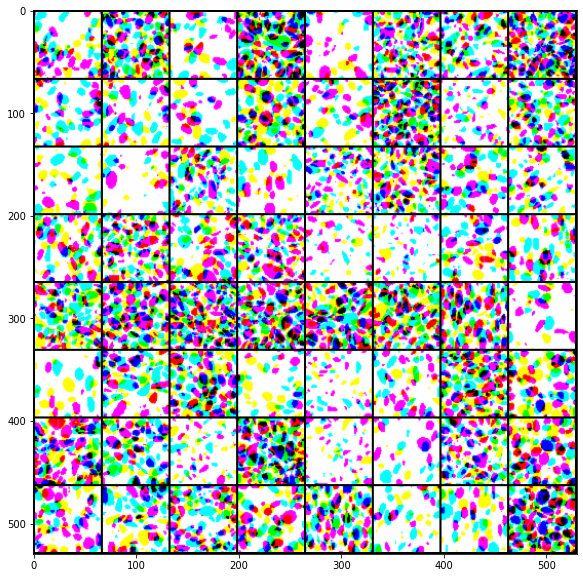

In [34]:
reload(dataset)
dm.prepare_data()
dm.setup(stage="fit")
first_batch = next(iter(dm.train_dataloader()))

images, labels = first_batch[0], first_batch[1]
grid = utils.make_grid(images)
fig = plt.figure(figsize=(40, 10))
plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.show()


# Network definition

The next step is to define our model. This model is inspired by VGG11:

* we define several convulational blocks.
* each of this block is sequence of:
  * convulational layer with `kernel_size=3, padding=1`
  * activation function, here it is the `ReLU`
  * max pooling layer with `kernel_size=2, stride=2` which aims at reducing the size of the convolutional layers

In [37]:
class PreTrainedVGG(models.BaseModel):
    def __init__(self, config, scaler=None):
        super().__init__(config)

        self.config = config
        self.config["model_type"] = type(self)
        self.scaler = scaler

        self.configure_model()
        self.configure_criterion()
        self.configure_metrics()

    def configure_model(self):
        assert self.config["total_layers"] >= self.config["fixed_layers"]
        vgg = pretrained_models.vgg16(pretrained=True)
        self.layers = nn.Sequential(*(list(vgg.features.children())[:40]))
        for idx, child in enumerate(self.layers.children()):
            if idx < self.config["fixed_layers"]:
                for param in child.parameters():
                    param.requires_grad = False
            else:
                reset_parameters = getattr(child, "reset_parameters", None)
                if callable(reset_parameters):
                    child.reset_parameters()
        nb_channels, width, a = (
            self.layers(
                torch.rand(
                    (1, 3, self.config["input_width"], self.config["input_width"])
                )
            )
            .squeeze()
            .shape
        )
        self.layers.add_module(str(config["total_layers"]), nn.BatchNorm2d(nb_channels))
        input_fc = int(width ** 2 * nb_channels)
        # fully connected linear layers
        self.linear_layers = nn.Sequential(
            nn.Linear(in_features=input_fc, out_features=512),
            nn.ReLU(),
            nn.Dropout2d(0.5),
            nn.Linear(in_features=512, out_features=512),
            nn.ReLU(),
            nn.Dropout2d(0.5),
            nn.Linear(in_features=512, out_features=23),
        )

    def forward(self, x):
        x = self.layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x


model = PreTrainedVGG(config)
print(model)
total_params = sum(p.numel() for p in model.parameters())
print(f"[INFO]: {total_params:,} total parameters.")
model(torch.rand((1, 3, config["input_width"], config["input_width"])))


PreTrainedVGG(
  (layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, di

tensor([[-0.0193, -0.0566, -0.0250,  0.0409, -0.0023, -0.0349,  0.0143, -0.0308,
         -0.0103, -0.0093,  0.0420,  0.0233, -0.0214,  0.0051,  0.0082,  0.0230,
          0.0124,  0.0118,  0.0116, -0.0020, -0.0281, -0.0184,  0.0061]],
       grad_fn=<AddmmBackward0>)

# Checkpoint

We had 2 checkpoints to our training:

* one for saving our model every time we have a minimum in the validation loss 
* one for saving the model's and data module script

In [30]:
model_checkpoint = pl.callbacks.model_checkpoint.ModelCheckpoint(
    dirpath=run.dir if "run" in locals() else "tmp/",
    filename="{epoch}-{val_loss:.3f}",
    monitor="val_loss",
    mode="min",
    verbose=True,
    save_last=True,
)

script_checkpoint = training.ScriptCheckpoint(
    dirpath=run.dir if "run" in locals() else "tmp/",
)

callbacks = [script_checkpoint]
log = None
if config["job_type"] == "train":
    callbacks.append(model_checkpoint)
    print(f"[INFO]: saving models.")
if config["job_type"] == "debug":
    log = "all"


# Training

We then train our model.

In [31]:
if config["log_wandb"]:
    wandb_logger = pl.loggers.WandbLogger()
    wandb_logger.watch(model, log=log, log_graph=True)
else:
    wandb_logger = None
trainer = pl.Trainer(
    max_epochs=150,
    callbacks=callbacks,
    logger=wandb_logger,
    devices="auto",
    accelerator="auto",
    # limit_train_batches=0.1,
    # limit_val_batches=0.1,
    # log_every_n_steps=1,
)
trainer.fit(
    model,
    datamodule=dm,
)


/home/matias/.pyenv/versions/3.9.8/envs/gt/lib/python3.9/site-packages/pytorch_lightning/loggers/wandb.py:341: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/matias/.pyenv/versions/3.9.8/envs/gt/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(

  | Name          | Type       | Params
---------------------------------------------
0 | layers        | Sequential | 260 K 
1 | linear_layers | Sequential | 537 K 
2 | criterion  

Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]